In [1]:
# Library
import pandas as pd
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib import cm

cmaps = cm.get_cmap('Set1')

In [2]:
filename = 'jobstreet_review.csv'
df = pd.read_csv(filename)

In [3]:
# get review statistics (sum, mean, std)
def get_statistics(df, measure):
    reviews = [5 for i in range(int(df['5']))] \
        + [4 for i in range(int(df['4']))] \
            + [3 for i in range(int(df['3']))] \
                + [2 for i in range(int(df['2']))] \
                    + [1 for i in range(int(df['1']))] \

    if measure == 'mean':
        return np.round(np.mean(np.array(reviews)),3)
    elif measure == 'std':
        return np.round(np.std(np.array(reviews), ddof=1),3)
    elif measure == 'sum':
        return df['5'] + df['4'] + df['3'] + df['2'] + df['1']
    else:
        Exception('Not Implemented')

df['sum_review'] = df.apply(lambda x: get_statistics(x, 'sum'), axis=1)
df['mean_review'] = df.apply(lambda x: get_statistics(x, 'mean'), axis=1)
df['std_review'] = df.apply(lambda x: get_statistics(x, 'std'), axis=1)

In [4]:
# get overall statistics
df = df.append({'company_name': 'Overall'}, ignore_index=True)
df.loc[df.company_name == 'Overall', '5'] = df['5'].sum()
df.loc[df.company_name == 'Overall', '4'] = df['4'].sum()
df.loc[df.company_name == 'Overall', '3'] = df['3'].sum()
df.loc[df.company_name == 'Overall', '2'] = df['2'].sum()
df.loc[df.company_name == 'Overall', '1'] = df['1'].sum()

df.loc[df.company_name == 'Overall', 'sum_review'] = df.loc[df.company_name == 'Overall',:].apply( \
    lambda x: get_statistics(x, 'sum'), axis=1)
df['mean_review'] = df.apply(lambda x: get_statistics(x, 'mean'), axis=1)
df['std_review'] = df.apply(lambda x: get_statistics(x, 'std'), axis=1)

In [5]:
# rank by weighted mean review
# techniques used in IMDb review
# ref: https://math.stackexchange.com/questions/41459/how-can-i-calculate-most-popular-more-accurately/41513#41513
# examples: https://www.animenewsnetwork.com/encyclopedia/ratings-anime.php#best_bayesian

# weighted rank (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C
#  where:
#   R = average review for the company = (mean_review)
#   v = number of review for the company = (sum_review)
#   m = minimum num of review required to be listed in the analysis (5 review)
#   C = the mean review across the whole report (4.318)

def weighted_mean_review(df):
    R = df['mean_review']
    v = df['sum_review']
    m = 5
    C = 4.318
    return (v / (v+m)) * R + (m / (v+m)) * C

df['weighted_mean_review'] = df.apply(lambda x: weighted_mean_review(x), axis=1)

In [6]:
# rank by statistics in posterior distribution
# using Normal-Normal conjugate prior to calculate posterior distribution
# applying method from book "Probabilistic Programming & Bayesian Methods for Hackers"
# example: How to order Reddit submissions in Chapter 4
# ref: https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter4_TheGreatestTheoremNeverTold/Ch4_LawOfLargeNumbers_PyMC3.ipynb

def get_statistics_posterior_distribution(df, measure):

    # parameter of gaussian (normal) prior
    mu0, s0, n0 = 0, 1, 0  # weak prior distribution

    # updating Gaussian prior
    m, s, n = df['mean_review'], df['std_review'], df['sum_review']
    inv_vars = n0 / np.power(s0, 2), n / np.power(s, 2)
    mu = np.average((mu0, m), weights=inv_vars)
    sd = 1 / np.sqrt(np.sum(inv_vars))

    # sample posterior
    num_samples = 20000
    posterior = norm(loc=mu, scale=sd).rvs(num_samples)

    if measure == 'mean':
        return np.round(np.mean(posterior),3)
    elif measure == 'std':
        return np.round(np.std(posterior, ddof=1),3)
    elif 'p' in measure:
        return np.round(np.percentile(posterior, int(measure[1:])),3)
    elif measure == 'least_val95':
        return np.sort(posterior)[int(0.05 * num_samples)]
    else:
        Exception('Not Implemented')

df['mean_posterior'] = df.apply(lambda x: get_statistics_posterior_distribution(x, 'mean'), axis=1)
df['std_posterior'] = df.apply(lambda x: get_statistics_posterior_distribution(x, 'std'), axis=1)
df['p25_posterior'] = df.apply(lambda x: get_statistics_posterior_distribution(x, 'p25'), axis=1)
df['p75_posterior'] = df.apply(lambda x: get_statistics_posterior_distribution(x, 'p75'), axis=1)
df['least_plausible_val95_posterior'] = df.apply(lambda x: get_statistics_posterior_distribution(x, 'least_val95'), axis=1)

showed_columns = ['company_name', '5', '4', '3', '2', '1', 'sum_review', 'mean_review', 'std_review', 'weighted_mean_review', 'p25_posterior', 'mean_posterior', 'std_posterior']

In [7]:
# Top 10 company ranked by mean_review
df[showed_columns].sort_values(by=['mean_review'], ascending=False, ignore_index=True).head(10)

,company_name,5,4,3,2,1,sum_review,mean_review,std_review,weighted_mean_review,p25_posterior,mean_posterior,std_posterior
0,Payfazz,10.0,2.0,0.0,0.0,0.0,12.0,4.833,0.389,4.681529,4.757,4.834,0.112
1,HappyFresh,14.0,2.0,2.0,0.0,0.0,18.0,4.667,0.686,4.591130,4.559,4.667,0.160
2,Fore Coffee,8.0,4.0,0.0,0.0,0.0,12.0,4.667,0.492,4.564353,4.572,4.667,0.144
3,Tiket,23.0,9.0,0.0,1.0,0.0,33.0,4.636,0.653,4.594158,4.560,4.636,0.114
4,DANA,4.0,0.0,1.0,0.0,0.0,5.0,4.600,0.894,4.459000,4.334,4.597,0.399
5,Mekari,51.0,14.0,1.0,0.0,3.0,69.0,4.594,0.896,4.575351,4.520,4.595,0.109
6,PegiPegi,22.0,8.0,4.0,0.0,0.0,34.0,4.529,0.706,4.501949,4.448,4.528,0.121
7,Zenius,6.0,1.0,0.0,1.0,0.0,8.0,4.500,1.069,4.430000,4.250,4.500,0.379
8,Blibli,79.0,39.0,15.0,0.0,1.0,134.0,4.455,0.752,4.450072,4.411,4.455,0.065
9,GoJek,145.0,74.0,19.0,6.0,1.0,245.0,4.453,0.775,4.450300,4.420,4.453,0.049


In [8]:
# Top 10 company ranked by weighted_mean_review
df[showed_columns].sort_values(by=['weighted_mean_review'], ascending=False, ignore_index=True).head(10)

,company_name,5,4,3,2,1,sum_review,mean_review,std_review,weighted_mean_review,p25_posterior,mean_posterior,std_posterior
0,Payfazz,10.0,2.0,0.0,0.0,0.0,12.0,4.833,0.389,4.681529,4.757,4.834,0.112
1,Tiket,23.0,9.0,0.0,1.0,0.0,33.0,4.636,0.653,4.594158,4.560,4.636,0.114
2,HappyFresh,14.0,2.0,2.0,0.0,0.0,18.0,4.667,0.686,4.591130,4.559,4.667,0.160
3,Mekari,51.0,14.0,1.0,0.0,3.0,69.0,4.594,0.896,4.575351,4.520,4.595,0.109
4,Fore Coffee,8.0,4.0,0.0,0.0,0.0,12.0,4.667,0.492,4.564353,4.572,4.667,0.144
5,PegiPegi,22.0,8.0,4.0,0.0,0.0,34.0,4.529,0.706,4.501949,4.448,4.528,0.121
6,DANA,4.0,0.0,1.0,0.0,0.0,5.0,4.600,0.894,4.459000,4.334,4.597,0.399
7,GoJek,145.0,74.0,19.0,6.0,1.0,245.0,4.453,0.775,4.450300,4.420,4.453,0.049
8,Blibli,79.0,39.0,15.0,0.0,1.0,134.0,4.455,0.752,4.450072,4.411,4.455,0.065
9,Tokopedia,145.0,72.0,19.0,4.0,3.0,243.0,4.449,0.808,4.446359,4.413,4.449,0.051


In [9]:
# Top 10 company ranked by p25 posterior distribution
df[showed_columns].sort_values(by=['p25_posterior'], ascending=False, ignore_index=True).head(10)

,company_name,5,4,3,2,1,sum_review,mean_review,std_review,weighted_mean_review,p25_posterior,mean_posterior,std_posterior
0,Payfazz,10.0,2.0,0.0,0.0,0.0,12.0,4.833,0.389,4.681529,4.757,4.834,0.112
1,Fore Coffee,8.0,4.0,0.0,0.0,0.0,12.0,4.667,0.492,4.564353,4.572,4.667,0.144
2,Tiket,23.0,9.0,0.0,1.0,0.0,33.0,4.636,0.653,4.594158,4.560,4.636,0.114
3,HappyFresh,14.0,2.0,2.0,0.0,0.0,18.0,4.667,0.686,4.591130,4.559,4.667,0.160
4,Mekari,51.0,14.0,1.0,0.0,3.0,69.0,4.594,0.896,4.575351,4.520,4.595,0.109
5,PegiPegi,22.0,8.0,4.0,0.0,0.0,34.0,4.529,0.706,4.501949,4.448,4.528,0.121
6,GoJek,145.0,74.0,19.0,6.0,1.0,245.0,4.453,0.775,4.450300,4.420,4.453,0.049
7,Tokopedia,145.0,72.0,19.0,4.0,3.0,243.0,4.449,0.808,4.446359,4.413,4.449,0.051
8,Blibli,79.0,39.0,15.0,0.0,1.0,134.0,4.455,0.752,4.450072,4.411,4.455,0.065
9,Grab,172.0,94.0,32.0,3.0,3.0,304.0,4.411,0.795,4.409495,4.380,4.412,0.046


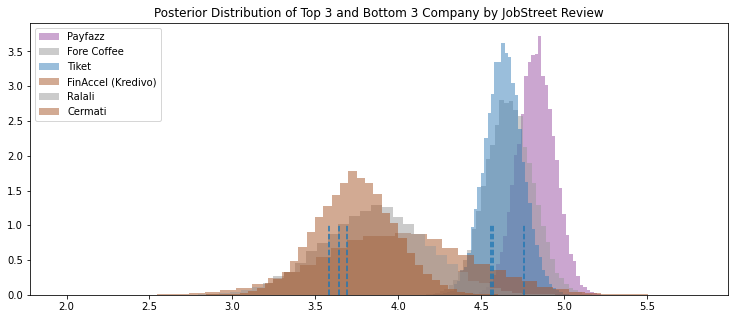

In [10]:
# Plot top 3 and bottom 3 posterior distribution

def plot_posterior_dist(df):
    # parameter of gaussian (normal) prior
    mu0, s0, n0 = 0, 1, 0  # weak prior distribution

    # update prior and sample posterior
    num_samples = 20000

    plt.figure(figsize=(12.5,5))
    plt.title('Posterior Distribution of Top 3 and Bottom 3 Company by JobStreet Review')

    n = df.shape[0] # number of rows
    for i in range(n):
        df_temp = df.iloc[i,:] # access specific row
        # updating Gaussian prior
        m, s, n = df_temp['mean_review'], df_temp['std_review'], df_temp['sum_review']
        inv_vars = n0 / np.power(s0, 2), n / np.power(s, 2)
        mu = np.average((mu0, m), weights=inv_vars)
        sd = 1 / np.sqrt(np.sum(inv_vars))

        posterior = norm(loc=mu, scale=sd).rvs(num_samples)

        plt.hist(posterior, histtype='stepfilled', bins=40, alpha=0.5, 
        lw=2, label=df_temp['company_name'], color=cmaps(np.random.rand()), density=True)

        p25 = np.percentile(posterior, 25)

        plt.vlines(p25, ymin=0, ymax=1, linestyles='dashed')
    
    plt.legend(loc='upper left')

# Order the company by p25
df = df[df.company_name != 'Overall'].sort_values(by='p25_posterior', ascending=False, ignore_index=True)
data = df.head(3).append(df.tail(3))
plot_posterior_dist(data)

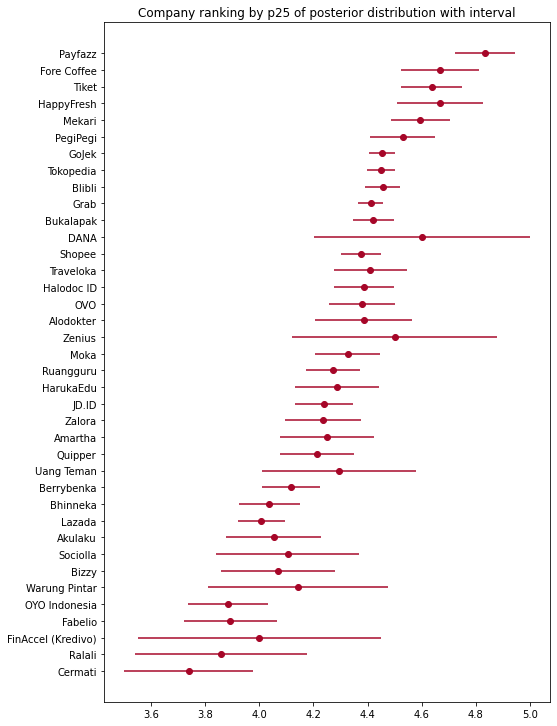

In [11]:
# plot interval posterior distribution
# notice that mean_review doesn't have strong pattern
# if we take consideration the uncertainty by using bayesian analysis

data = df[df.company_name != 'Overall'].sort_values(by='p25_posterior', ascending=True)
x = data['mean_review']
y = data['company_name']
# error = np.concatenate((data['p25_posterior'].values.reshape(1,-1), data['p75_posterior'].values.reshape(1,-1)), axis=0) # asymmetric error
error = data['std_posterior'] # symmetric error

plt.figure(figsize=(8,12.5))
plt.title('Company ranking by p25 of posterior distribution with interval')
plt.errorbar(x=x, y=y, xerr=error, capsize=0, fmt='o', color="#A60628")
filename='company-rank-by-p25-posterior-dist'
plt.savefig(filename)

plt.show()

In [12]:
# Full company list ranked by p25 posterior distribution
df[showed_columns]

,company_name,5,4,3,2,1,sum_review,mean_review,std_review,weighted_mean_review,p25_posterior,mean_posterior,std_posterior
0,Payfazz,10.0,2.0,0.0,0.0,0.0,12.0,4.833,0.389,4.681529,4.757,4.834,0.112
1,Fore Coffee,8.0,4.0,0.0,0.0,0.0,12.0,4.667,0.492,4.564353,4.572,4.667,0.144
2,Tiket,23.0,9.0,0.0,1.0,0.0,33.0,4.636,0.653,4.594158,4.560,4.636,0.114
3,HappyFresh,14.0,2.0,2.0,0.0,0.0,18.0,4.667,0.686,4.591130,4.559,4.667,0.160
4,Mekari,51.0,14.0,1.0,0.0,3.0,69.0,4.594,0.896,4.575351,4.520,4.595,0.109
5,PegiPegi,22.0,8.0,4.0,0.0,0.0,34.0,4.529,0.706,4.501949,4.448,4.528,0.121
6,GoJek,145.0,74.0,19.0,6.0,1.0,245.0,4.453,0.775,4.450300,4.420,4.453,0.049
7,Tokopedia,145.0,72.0,19.0,4.0,3.0,243.0,4.449,0.808,4.446359,4.413,4.449,0.051
8,Blibli,79.0,39.0,15.0,0.0,1.0,134.0,4.455,0.752,4.450072,4.411,4.455,0.065
9,Grab,172.0,94.0,32.0,3.0,3.0,304.0,4.411,0.795,4.409495,4.380,4.412,0.046
